# OneEye: Military Airfiled Monitoring with Computer Vision
## AAI-521 Team 1 Final Project

Team 1:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  December 11, 2023

GitHub Repository: https://github.com/t4ai/one-eye-aircraft-detector

In [37]:
# import base libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pathlib
import PIL
import PIL.Image
import xml.etree.ElementTree as ET

# import keras and supporting libraries
import keras
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from keras.datasets import mnist, cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras.layers import Dense
from keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

## Exploratory Data Analysis

Scan the images and bounding box labels to understand the nature of the dataset.  Objectives are:

1.  Visualize some sample images
2.  Understand the distribution of image sizes
3.  Understand the distribution of image channels
4.  Analyze the class balances and representation across the dataset
5.  Visualize sample images with horizontal bounding boxes overlaid
6.  Visualize sample images with oriented bounding boxes overlaid

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# set root folder where dataset is located
ROOT_DIR = '/content/drive/MyDrive/USD/datasets/military_aircraft'
raw_img_dir = pathlib.Path(ROOT_DIR + '/JPEGImages/')
horizontal_xml_dir = pathlib.Path(ROOT_DIR + '/Annotations/Horizontal Bounding Boxes/').with_suffix('')
oriented_xml_dir = pathlib.Path(ROOT_DIR + '/Annotations/Oriented Bounding Boxes/').with_suffix('')

### Visualize some sample images

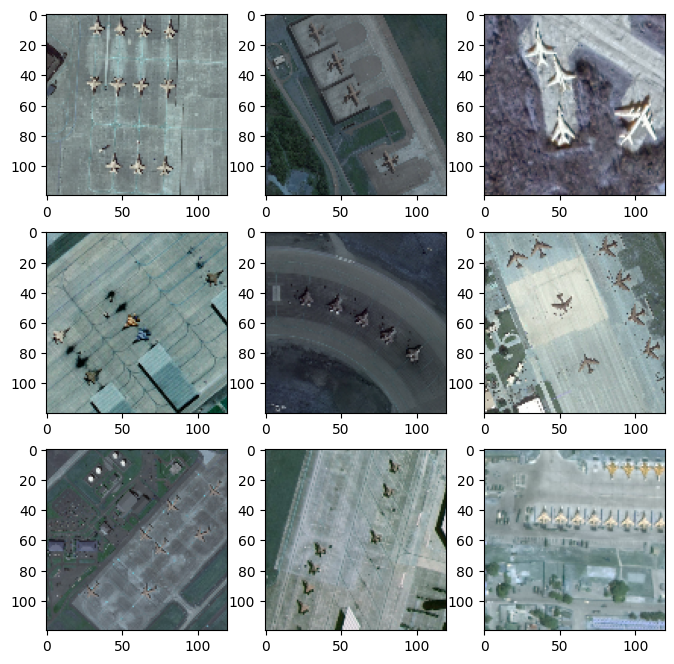

In [82]:
# get paths to images
img_paths = list(raw_img_dir.glob('*.jpg'))

# visualize some samples from the training data
plt.figure(figsize=(8,8))
for i in range(9):
    rand_img = np.random.randint(0, len(img_paths))
    image = cv2.imread(str(img_paths[rand_img]))
    plt.subplot(3,3,i+1)
    plt.grid(False)
    plt.imshow(cv2.resize(image, (120, 120)))
plt.show()

### Create a distribution of the image sizes to understand the range of sizes

In [76]:
# helper function to read image files and extract characteristics
def extract_image_characteristics(image_path):

    resolutions = []
    color_distributions = []
    image_channels = []

    imgs = list(image_path.glob('*.jpg'))
    for img in imgs:
        test_img = cv2.imread(str(img))

        # store resolution
        shape = test_img.shape
        resolution = [shape[0], shape[1]]
        resolutions.append(resolution)

        # store image channel count
        if(len(test_img.shape) == 2):
          image_channels.append(1)
        else:
          image_channels.append(test_img.shape[2])

    return resolutions, image_channels

In [77]:
# compile distribution of sizes
resolution_dist, channel_dist = extract_image_characteristics(raw_img_dir)

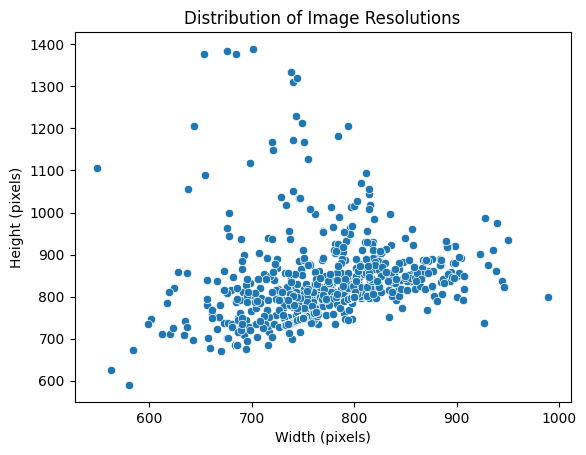

In [79]:
# Plot a scatter plot of the image resolutions
resolution_dist = np.array(resolution_dist)
#plt.figure(figsize=(6,6))
#plt.scatter(resolution_dist[:, 0], resolution_dist[:, 1])
sns.scatterplot(x=resolution_dist[:, 0], y=resolution_dist[:, 1])
plt.title("Distribution of Image Resolutions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()

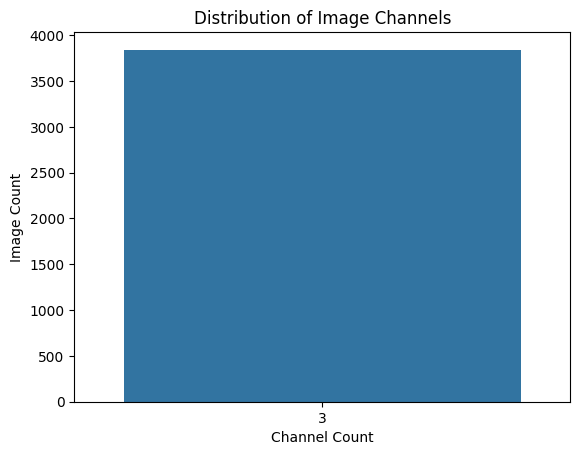

In [81]:
# Plot histogram to visually analyze distribution
sns.countplot(x=channel_dist)
plt.title("Distribution of Image Channels")
plt.xlabel( "Channel Count" , size = 10)
plt.ylabel( "Image Count" , size = 10)
plt.show()

### Load bounding box data and extract class distributions


In [ ]:
# helper function to load xml file into data structure


## Data Preparation: move the images into separate train/test directories so we can use tf loader from directory